# BigBrain workshop short tutorial: Retrieving a BigBrain 1 micron patch 

In [1]:
import siibra
import matplotlib.pyplot as plt
%matplotlib notebook
from nilearn import plotting

[siibra:INFO] Version: 0.4a68
[siibra:WARNING] This is a development release. Use at your own risk.
[siibra:INFO] Please file bugs and issues at https://github.com/FZJ-INM1-BDA/siibra-python.


## Step 1: Load a coronal 2D annotation pasted over from siibra-explorer annotation mode

In [2]:
structure='''{
  "@id": "c882cfb9",
  "@type": "tmp/poly",
  "coordinateSpace": {
    "@id": "minds/core/referencespace/v1.0.0/a1655b99-82f1-420f-a3c2-fe80fd4c8588"
  },
  "coordinates": [
    [
      {
        "@id": "26a2b847",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": -35.721144,
        "unit": {
          "@id": "id.link/mm"
        }
      },
      {
        "@id": "d7f76f43",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": -1.87,
        "unit": {
          "@id": "id.link/mm"
        }
      },
      {
        "@id": "365dfad0",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": 35.022472,
        "unit": {
          "@id": "id.link/mm"
        }
      }
    ],
    [
      {
        "@id": "4e160292",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": -33.692304,
        "unit": {
          "@id": "id.link/mm"
        }
      },
      {
        "@id": "12cb8664",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": -1.87,
        "unit": {
          "@id": "id.link/mm"
        }
      },
      {
        "@id": "71387d2a",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": 36.182644,
        "unit": {
          "@id": "id.link/mm"
        }
      }
    ],
    [
      {
        "@id": "dafcc00b",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": -32.572944,
        "unit": {
          "@id": "id.link/mm"
        }
      },
      {
        "@id": "5d00aa25",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": -1.87,
        "unit": {
          "@id": "id.link/mm"
        }
      },
      {
        "@id": "f5aab4e8",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": 34.328704,
        "unit": {
          "@id": "id.link/mm"
        }
      }
    ],
    [
      {
        "@id": "389a2439",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": -35.639524,
        "unit": {
          "@id": "id.link/mm"
        }
      },
      {
        "@id": "74e3ecaa",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": -1.87,
        "unit": {
          "@id": "id.link/mm"
        }
      },
      {
        "@id": "90fece85",
        "@type": "https://openminds.ebrains.eu/core/QuantitativeValue",
        "value": 35.185712,
        "unit": {
          "@id": "id.link/mm"
        }
      }
    ]
  ],
  "closed": true
}'''

In [3]:
# we can directly instantiate a location object from the structure in siibra
# the annotation is cast to a siibra pointset.
# Note that it has already the proper reference space encoded!
points = siibra.from_json(structure)
print(points)

Loading preconfigured Space instances: 100%|███████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 2540.80it/s]

Set of points BigBrain microscopic template (histology): (-35.71875,-1.8701171875,35.03125), (-33.6875,-1.8701171875,36.1875), (-32.5625,-1.8701171875,34.34375), (-35.625,-1.8701171875,35.1875)


In [6]:
# we choose as a region (or volume) of interst the bounding box of the points
voi = points.boundingbox

## Step 2: Extract a lower resolution surrounding cube from the BigBrain template

In [7]:
# get a cube of BigBrain context centered at this annotation
bigbrain = siibra.get_template('bigbrain')
cube = bigbrain.fetch(
    voi=voi.centroid.get_enclosing_cube(width_mm=10),
    resolution_mm=0.32
)

## Step 3:  Find the related 1 micron section to extract a 1 micron cortical patch

Note that siibra implements a lazy loading strategy. We find the 1 micron sections as data features with a bounding box. Retrieval of actual image data is postponed until we call `fetch` explitly.

Here we fetch with a volume of interest defintion (the bounding box of the annotation), which makes fetching the full resolution feasible. 

With the current siibra version, we fist retrieve all 1 micron sections and intersect explictly.
The next siibra version allows to query features directly with the annotation's bounding box.

In [8]:
# all cellbody stained 1 micron sections anchored to BigBrain
sections = siibra.features.get(
    siibra.spaces.get('bigbrain'),
    siibra.features.cellular.CellbodyStainedSection
)

# the ones intersecting with the coronal 2D annotation
matched_sections = [s for s in sections if s.anchor.location.intersects(voi)]
assert len(matched_sections) > 0 

# extract the full resolution patch
patch_1mu = matched_sections[0].fetch(voi=voi, resolution_mm=-1)

Matching CellbodyStainedSection to Space: BigBrain microscopic template (histology): 100%|███████| 145/145 [00:00<00:00, 458999.31it/s]
[siibra:WARNING] Bounding box in voxel space will be enlarged to voxel size 1 along axis 1.


### Step 4: Plot the 3D context and 2D patch

<IPython.core.display.Javascript object>


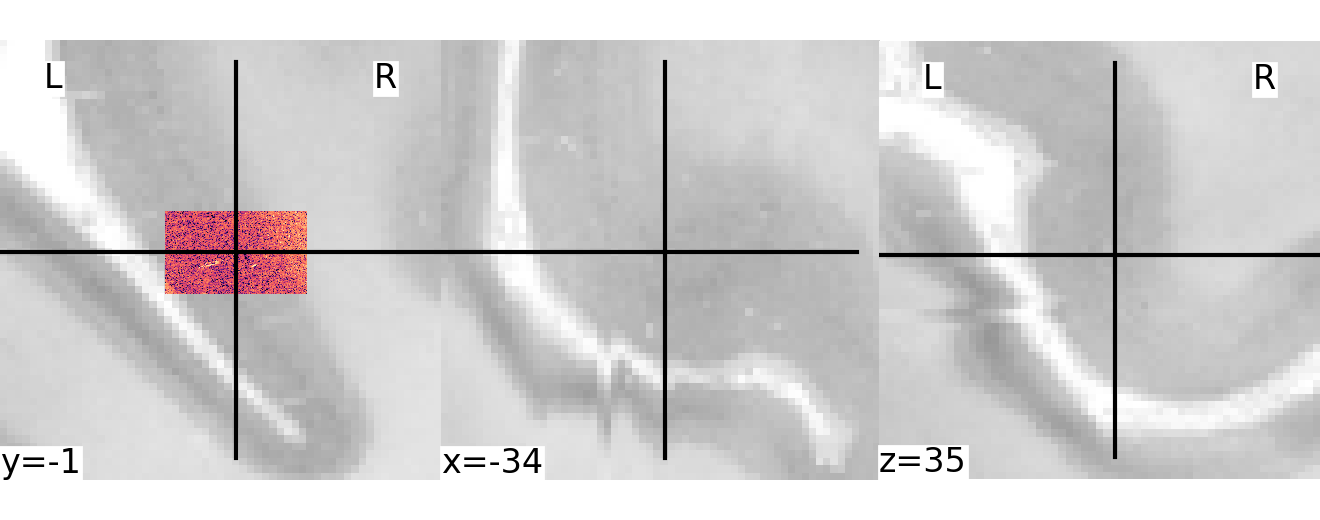

In [9]:
# plot a composite 3D view with nilearn
view=plotting.plot_img(cube, cmap='gray', cut_coords=tuple(voi.center), vmin=0, vmax=255)
view.add_overlay(patch_1mu, cmap='magma')

<IPython.core.display.Javascript object>


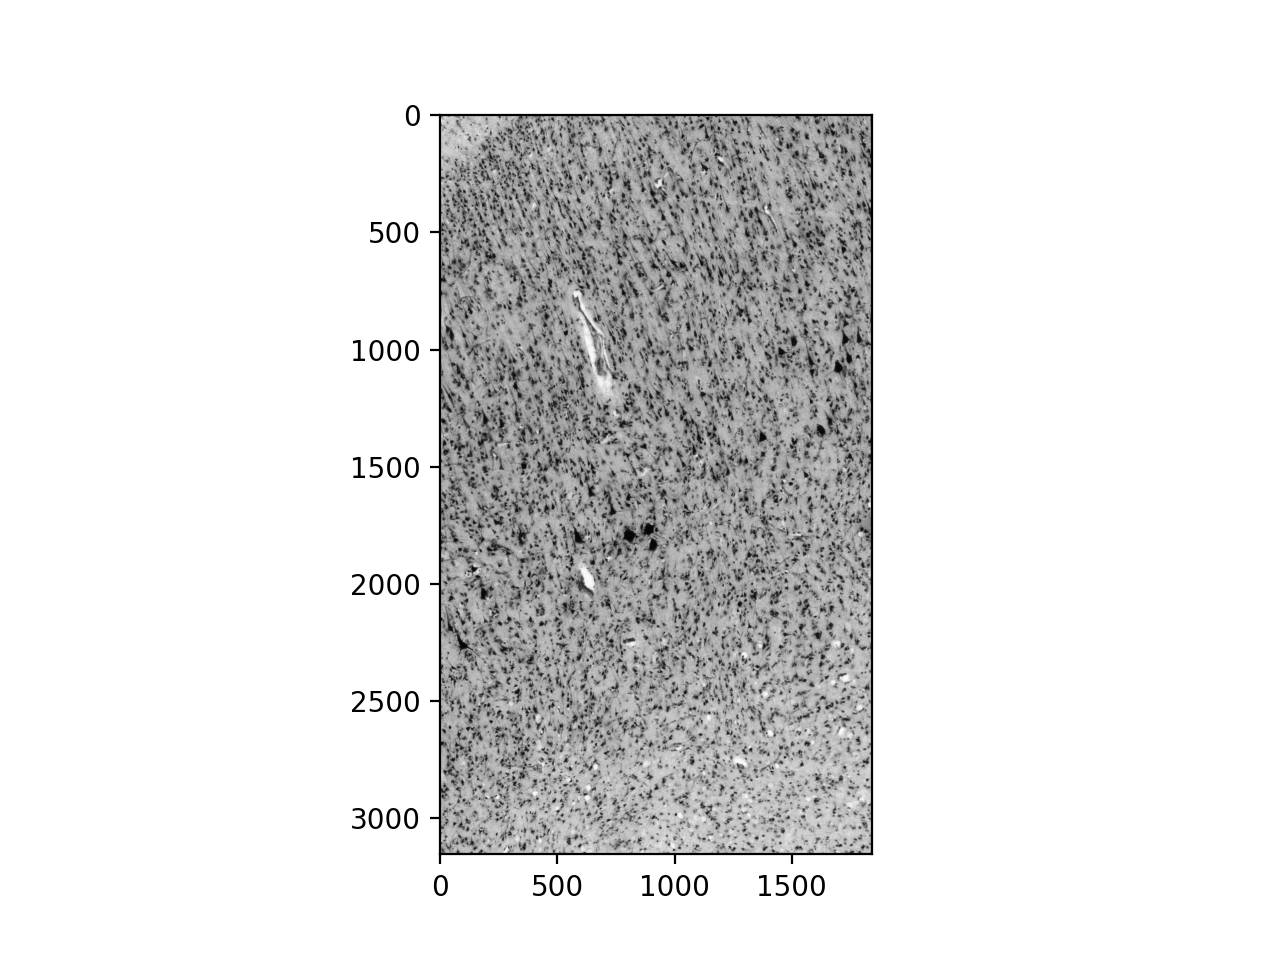

In [11]:
# plot only the 1 micron patch
plt.figure()
plt.imshow(patch_1mu.get_fdata().squeeze(), cmap='gray')